In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import numpy as np
from datasets import load_dataset
import torch
import torch.nn as nn



In [3]:

dataset = load_dataset("ag_news")
train_data = dataset['train']
print(train_data[0])


Using custom data configuration default
Reusing dataset ag_news (C:\Users\asira\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [27]:
from sentence_transformers import SentenceTransformer

model_name = "all-MiniLM-L6-v2"  # small, fast, 384-dim embeddings
embedder = SentenceTransformer(model_name)

# For demo: use first 2000 samples only
texts = [sample['text'] for sample in train_data.select(range(2000))]
embeddings = embedder.encode(texts, convert_to_tensor=True)

In [16]:
embeddings


import torch.nn as nn

class EmbedReducer(nn.Module):
    def __init__(self, input_dim=384, output_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out



In [ ]:
from torch.utils.data import TensorDataset,DataLoader
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detach=embeddings.detach().cuda()   #clears 
dataset=TensorDataset(detach,detach)
loader=DataLoader(dataset,batch_size=64,shuffle=True)
model = EmbedReducer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #optimi
loss_fn_MSE= nn.MSELoss()


In [ ]:
for epoch in range(10):
    total_loss = 0
    for batch_x, _ in loader:
        batch_x = batch_x.to(device).float()
        output = model(batch_x)
        loss = loss_fn_MSE(output, batch_x)
        
        optimizer.zero_grad()
        loss.backward()               
        optimizer.step()
        total_loss += loss.item()
    

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1, Loss: 0.0032
Epoch 2, Loss: 0.0023
Epoch 3, Loss: 0.0021
Epoch 4, Loss: 0.0019
Epoch 5, Loss: 0.0017
Epoch 6, Loss: 0.0016
Epoch 7, Loss: 0.0015
Epoch 8, Loss: 0.0014
Epoch 9, Loss: 0.0013
Epoch 10, Loss: 0.0013


In [23]:
model.eval()
with torch.no_grad():
    reduced_embeddings = model(detach.to(device).float()).cpu().numpy()


In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)


In [ ]:
torch.cuda.is_available()
torch.cuda.current_device()

torch.cuda.get_device_name()


True

In [25]:
sil_score = silhouette_score(reduced_embeddings, cluster_labels)
db_score = davies_bouldin_score(reduced_embeddings, cluster_labels)
ch_score = calinski_harabasz_score(reduced_embeddings, cluster_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.0800
Davies-Bouldin Index: 3.0056
Calinski-Harabasz Index: 131.6337


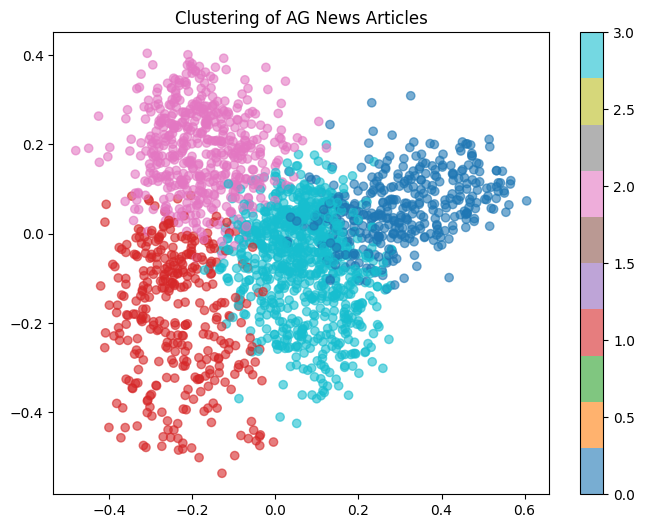

In [26]:
pca = PCA(n_components=2)
coords = pca.fit_transform(reduced_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
plt.title("Clustering of AG News Articles")
plt.colorbar()
plt.show()

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'